In [138]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
from skforecast.datasets import fetch_dataset
import sys
from scipy.stats.mstats import winsorize
import seaborn as sns

#modulo funciones
import funciones as func

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import plotly_express as px
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

from lightgbm import LGBMRegressor

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('once')

In [139]:
dfe = pd.read_csv("C:\Pablo\datasets\\household_power_consumption.txt", delimiter=";", low_memory=False)

<>:1: DeprecationWarning:

invalid escape sequence '\P'



In [140]:
dfe.replace(to_replace='?',value=np.nan,inplace=True)
#dfe.dropna(subset=['Sub_metering_3'],inplace=True)

In [141]:
float_cols = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
for col in float_cols:
    dfe[col] = dfe[col].apply(lambda x: func.flotante(x))

In [142]:
dfe['date_time'] = pd.to_datetime(dfe['Date'] + ' ' + dfe['Time'])

C:\Users\Pablo\AppData\Local\Temp\ipykernel_7508\3871453624.py:1: UserWarning:

Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.



In [143]:
from math import *

potencia aparente y factor de potencia

In [144]:
dfe.fillna(value=0,axis=0,inplace=True)
dfe.sort_values('date_time', inplace=True, ascending=True)

In [145]:
dfe['eficiencia'] = np.where(dfe['Global_reactive_power'] == 0,1,0)

# Potencia Aparente
pag = dfe.Global_active_power*1000
prg = dfe.Global_reactive_power*1000
potencia_aparente = (pag**2)+(prg**2)
potencia_aparente = potencia_aparente.apply(lambda x: sqrt(x))
dfe.insert(loc=4,column='apparent_power',value=potencia_aparente)

# Factor de potencia
pf = (dfe.Global_active_power/(dfe.apparent_power/1000))
dfe.insert(loc=4,column='power_factor',value=pf)

# Ángulo de fase
angulo_fase = dfe.power_factor.values
angulo = []
angulo_radianes = 180/np.pi
for x in angulo_fase:
  angulo.append((acos(x))*angulo_radianes) # se multiplica por 180/pi para obtener el valor en grados
dfe.insert(loc=5,column='phase_angle',value=pd.Series(angulo))

# Impedancia
imp = (dfe.Voltage/dfe.Global_intensity)
dfe.insert(loc=5,column='impedance',value=imp)

# Ángulo de fase de corriente, corriente compleja y corriente compleja conjugada
dfe["theta_i"] = np.arctan(-dfe["Global_reactive_power"] / (dfe["Global_reactive_power"] * dfe["power_factor"]))
#dfe["I_complex"] = dfe["Global_intensity"] * (np.cos(dfe["theta_i"]) + 1j * np.sin(dfe["theta_i"]))
#dfe["I_complex_conjugado"] = np.array(dfe["I_complex"]).conjugate()

In [146]:
dfe.fillna(value=0,axis=0,inplace=True)

In [147]:
dfe.columns

Index(['Date', 'Time', 'Global_active_power', 'Global_reactive_power',
       'power_factor', 'impedance', 'phase_angle', 'apparent_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3', 'date_time', 'eficiencia', 'theta_i'],
      dtype='object')

In [148]:
dfe.sample(3)

Date      Time  Global_active_power  Global_reactive_power  \
323970    29/7/2007  16:54:00                0.276                  0.218   
1077839    3/1/2009  05:23:00                0.318                  0.098   
971698   21/10/2008  12:22:00                1.402                  0.048   

         power_factor   impedance  phase_angle  apparent_power  Voltage  \
323970       0.784737  168.514286    38.303622      351.710108   235.92   
1077839      0.955649  176.035714    17.128047      332.758170   246.45   
971698       0.999414   41.570690     1.960858     1402.821443   241.11   

         Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  \
323970                1.4             0.0             0.0             0.0   
1077839               1.4             0.0             0.0             0.0   
971698                5.8             0.0             0.0            19.0   

                  date_time  eficiencia   theta_i  
323970  2007-07-29 16:54:00           0 -0.905432  
1077839 2009-01-03 05:23:00           0 -0.808073  
971698  2008-10-21 12:22:00           0 -0.785691

In [149]:
dfe_promedio = dfe[['date_time','power_factor', 'impedance', 'phase_angle', 'apparent_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3', 'eficiencia', 'theta_i']]
dfe_suma = dfe[['date_time','Global_active_power', 'Global_reactive_power',]]

In [150]:
dfe_promedio = dfe_promedio.resample('H',on='date_time').mean()
dfe_suma = dfe_suma.resample('H',on='date_time').sum()
#dfe_h = dfe_h.resample('H',on='date_time').sum()

In [151]:
dfe_h = pd.merge(dfe_suma,dfe_promedio,how='inner',on='date_time')

In [152]:
dfe_h.sort_values('date_time', inplace=True, ascending=True)

# aNNs

Consiste en un conjunto de unidades, llamadas **neuronas artificiales**, conectadas entre sí para transmitirse señales. La información de entrada atraviesa la red neuronal (donde se somete a diversas operaciones) produciendo unos valores de salida.

Cada neurona está conectada con otras a través de unos enlaces. En estos enlaces el valor de salida de la neurona anterior es multiplicado por un valor de peso. Estos pesos en los enlaces pueden incrementar o inhibir el estado de activación de las neuronas adyacentes. Del mismo modo, a la salida de la neurona, puede existir una función limitadora o umbral, que modifica el valor resultado o impone un límite que no se debe sobrepasar antes de propagarse a otra neurona. Esta función se conoce como función de activación.

In [153]:
#columnas de correlacion perfecta con nuestro target
dfe_h.drop(columns=['apparent_power','Global_intensity','eficiencia'],inplace=True)

In [154]:
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

In [155]:
X = dfe_h.drop('Global_active_power', axis=1)
y = dfe_h['Global_active_power']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [156]:
# Normalize the features
#X = (X - X.mean()) / X.std()
model = keras.Sequential([
    # Input layer
    layers.Dense(14, activation='relu', input_shape=(X.shape[1],)),
    # Hidden layers
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    # Output layer
    layers.Dense(1)
])

c:\Users\Pablo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



### Compilado

En la compilacion se estructura:
- la función de pérdida (o función de costo) que cuantifica cuán bien o mal está desempeñándose el modelo con respecto a los datos de entrenamiento.
- El optimizador es un algoritmo que ajusta los pesos del modelo para minimizar la función de pérdida.
- Las métricas son medidas adicionales que se usan para evaluar el rendimiento del modelo durante y después del entrenamiento, pero no afectan el proceso de entrenamiento directamente.
- la configuración del Grafo Computacional: Se construye y optimiza el grafo computacional para realizar las operaciones de entrenamiento de manera eficiente.

In [157]:
model.compile(loss='mse', optimizer='adam')

### Entrenamiento

In [158]:
"""
# Metodo con early_stopping para evitar el overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])
"""

"\n# Metodo con early_stopping para evitar el overfitting\nearly_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)\n\nhistory = model.fit(X_train, y_train,\n                    epochs=10,\n                    batch_size=32,\n                    validation_data=(X_test, y_test),\n                    callbacks=[early_stopping])\n"

In [159]:
model.fit(X, y, epochs=3, batch_size=32)

Epoch 1/3
1081/1081 ━━━━━━━━━━━━━━━━━━━━ 2s 756us/step - loss: 1219.5325
Epoch 2/3
1081/1081 ━━━━━━━━━━━━━━━━━━━━ 1s 785us/step - loss: 91.1172
Epoch 3/3
1081/1081 ━━━━━━━━━━━━━━━━━━━━ 1s 854us/step - loss: 76.2677


### Evaluacion

In [160]:
model.evaluate(X, y)

1081/1081 ━━━━━━━━━━━━━━━━━━━━ 1s 597us/step - loss: 93.5405


68.49019622802734

In [161]:
predicts = model.predict(X_test)

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step


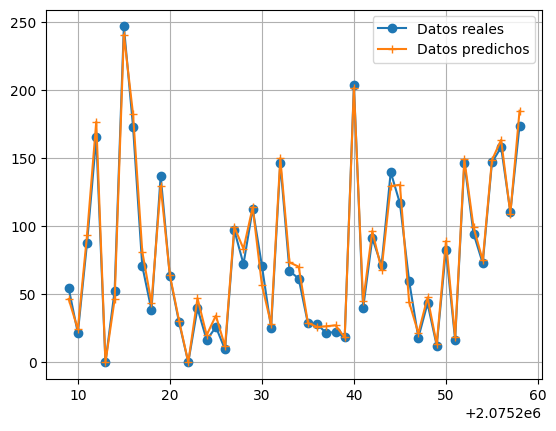

In [162]:
plt.plot(dfe.index[-50:],y_test[-50:],label='Datos reales',marker='o')
plt.plot(dfe.index[-50:],predicts[-50:],label='Datos predichos',marker='+')
plt.legend()
# Mostrar gráfico
plt.grid(True)
plt.show()

In [163]:
"""
#Reemplazar outliers por encima del limite inferior y por debajo del limite superior
def replace_outliers(column):
    q1 = column.quantile(0.25)
    q3 = column.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    column = column.where((column >= lower_bound) & (column <= upper_bound), 
                          other=column.clip(lower=lower_bound, upper=upper_bound))
    return column

dfe_h['Global_active_power'] = replace_outliers(dfe_h['Global_active_power'])
dfe_h['Global_reactive_power'] = replace_outliers(dfe_h['Global_reactive_power'])
dfe_h['power_factor'] = replace_outliers(dfe_h['power_factor'])
dfe_h['apparent_power'] = replace_outliers(dfe_h['apparent_power'])
dfe_h['Voltage'] = replace_outliers(dfe_h['Voltage'])
dfe_h['Global_intensity'] = replace_outliers(dfe_h['Global_intensity'])
"""

"\n#Reemplazar outliers por encima del limite inferior y por debajo del limite superior\ndef replace_outliers(column):\n    q1 = column.quantile(0.25)\n    q3 = column.quantile(0.75)\n    iqr = q3 - q1\n    lower_bound = q1 - 1.5 * iqr\n    upper_bound = q3 + 1.5 * iqr\n    \n    column = column.where((column >= lower_bound) & (column <= upper_bound), \n                          other=column.clip(lower=lower_bound, upper=upper_bound))\n    return column\n\ndfe_h['Global_active_power'] = replace_outliers(dfe_h['Global_active_power'])\ndfe_h['Global_reactive_power'] = replace_outliers(dfe_h['Global_reactive_power'])\ndfe_h['power_factor'] = replace_outliers(dfe_h['power_factor'])\ndfe_h['apparent_power'] = replace_outliers(dfe_h['apparent_power'])\ndfe_h['Voltage'] = replace_outliers(dfe_h['Voltage'])\ndfe_h['Global_intensity'] = replace_outliers(dfe_h['Global_intensity'])\n"

In [164]:
"""
# Normalizacion
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_val = df[feature_name].max()
        min_val = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_val) / (max_val - min_val)

    return result
dfe_norm = normalize(dfe_h[['Global_active_power','Global_reactive_power','Global_intensity','power_factor','apparent_power','Voltage']])
"""

"\n# Normalizacion\ndef normalize(df):\n    result = df.copy()\n    for feature_name in df.columns:\n        max_val = df[feature_name].max()\n        min_val = df[feature_name].min()\n        result[feature_name] = (df[feature_name] - min_val) / (max_val - min_val)\n\n    return result\ndfe_norm = normalize(dfe_h[['Global_active_power','Global_reactive_power','Global_intensity','power_factor','apparent_power','Voltage']])\n"

# Forescasting con LSTM(long short term memory)

In [165]:
datos = dfe.resample('H',on='date_time').sum()
datos.drop(columns=['apparent_power','Global_intensity','eficiencia'],inplace=True)
datos['Voltage'] = datos['Voltage']/60
datos['power_factor'] = datos['power_factor']/60
datos['impedance'] = datos['impedance']/60
datos['phase_angle'] = datos['phase_angle']/60

# Verificar que un índice temporal está completo
# ==============================================================================
(datos.index == pd.date_range(
                    start = datos.index.min(),
                    end   = datos.index.max(),
                    freq  = datos.index.freq)
).all()

True

## Porcion de los datos
- Conjunto de entrenamiento
- conjunto de validacion
- conjunto de test

La razon de la existencia del conjunto de validacion es que, el proceso de busqueda de los mejores hiperparametros, no debe hacerse sobre los datos de test, ya que se podria estar cayendo en sobreajuste del modelo.

In [166]:
datos = datos.loc['2007-01-01 17:24:00':'2009-06-01 00:00:00']
fin_train = '2009-02-28 00:00:00'
fin_validacion = '2009-05-01 00:00:00'

In [167]:
datos_train = datos.loc[:fin_train,:] # 2 años y 3 meses
datos_val = datos.loc[fin_train:fin_validacion,:] # 2 meses (Diferencia entre el final de los datos de train y la validacion)
datos_test = datos.loc[fin_validacion:,:] # 1 meses (fin de validacion a final de los datos)

print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas validacion : {datos_val.index.min()} --- {datos_val.index.max()}  (n={len(datos_val)})")
print(f"Fechas test : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")


Fechas train : 2007-01-01 18:00:00 --- 2009-02-28 00:00:00  (n=18919)
Fechas validacion : 2009-02-28 00:00:00 --- 2009-05-01 00:00:00  (n=1489)
Fechas test : 2009-05-01 00:00:00 --- 2009-06-01 00:00:00  (n=745)


## Visualizacion
grafico de la potencia o energia activa


In [168]:
"""
fig, ax = plt.subplots(figsize=(15,4))
datos_train.Global_active_power.plot(ax=ax, label='Entrenamiento',linewidth=1)
datos_val.Global_active_power.plot(ax=ax, label='Validacion',linewidth=1)
datos_test.Global_active_power.plot(ax=ax, label='Test',linewidth=1)
ax.set_title('Energia activa')
ax.legend()
"""

"\nfig, ax = plt.subplots(figsize=(15,4))\ndatos_train.Global_active_power.plot(ax=ax, label='Entrenamiento',linewidth=1)\ndatos_val.Global_active_power.plot(ax=ax, label='Validacion',linewidth=1)\ndatos_test.Global_active_power.plot(ax=ax, label='Test',linewidth=1)\nax.set_title('Energia activa')\nax.legend()\n"

## Grafico interactivo

In [169]:
datos.loc[:fin_train,'partition'] = 'train'
datos.loc[fin_train:fin_validacion,'partition'] = 'validation'
datos.loc[fin_validacion:,'partition'] = 'test'

fig = px.line(
    data_frame=datos.reset_index(),
    x = 'date_time',
    y = 'Global_active_power',
    color = 'partition',
    title = 'Number of users',
    width = 1200,
    height= 700
)
fig.show()
datos = datos.drop(columns='partition')

## Autocorrelacion
Tenes en consideracion, que al eliminar datos nulos, se pierde la continuidad temporal del dataset, lo que genera no poder visualizar la autocorrelacion del metodo acf(autocorrelación), para poder evitar esto se puede:
1- analizar el periodo de tiempo donde se encuentran los valores nulos y obviarlo(no usar ese periodo)
2- analizar el periodo de tiempo y continuarlo, rellenandolo con el metodo mean, forward fill o backward fill.
3- analizar el periodo de tiempo y cortarlo o dropearlo, usando otra manera de visualizar la autocorrelacion.

La autocorrelación (ACF) y la autocorrelación parcial (PACF) son medidas de asociación entre valores de serie actuales y pasadas e indican cuáles son los valores de series pasadas más útiles para predecir valores futuros.

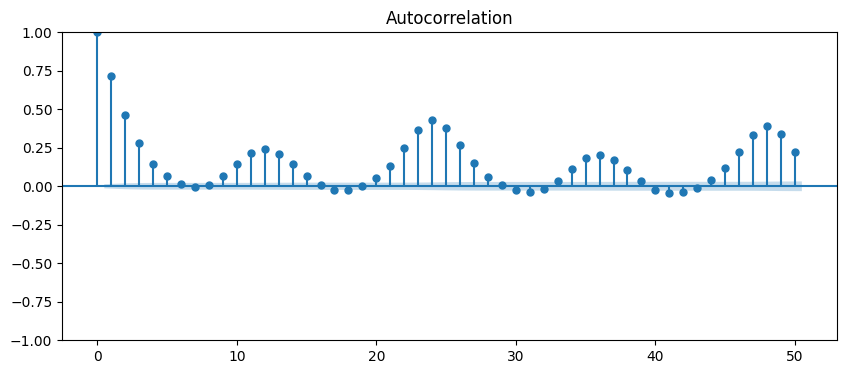

In [170]:
fig, ax = plt.subplots(figsize=(10,4))
plot_acf(datos.Global_active_power, ax= ax, lags=50)
plt.show()

Con el grafico de autocorrelacion, podemos observar que existe cierta correlacion, que aumenta con cierta frecuencia teniendo en cuenta que cada lag representado en el grafico corresponde a 1h

nota: tanto los graficos como los metodos plot_acf y plot_pacf tardan demasiado con instancias por minuto del dataset.
el metodo de autocorrelacion es mucho mas lento que el de autocorrelacion parcial

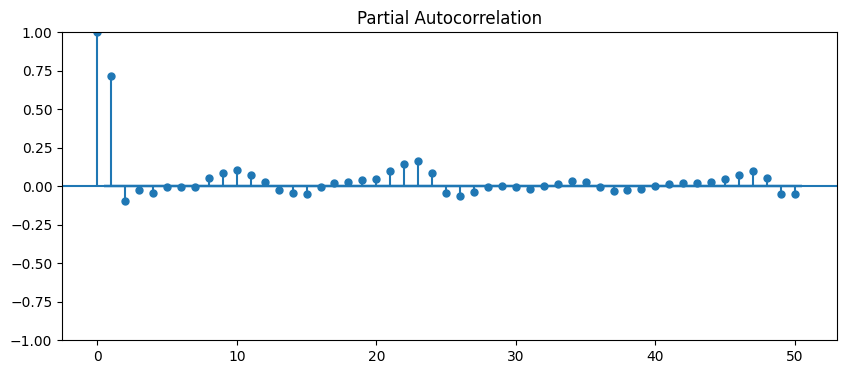

In [171]:
fig, ax = plt.subplots(figsize=(10,4))
plot_pacf(datos.Global_active_power, ax= ax, lags=50)
plt.show()

## Modelacion
- Crear el objeto forecaster(autoregresivo)
- Asignar el regresor, el modelo de alguna libreria de machine learning, en este caso LGBMRegressor(grading boosting).
- Se le asigna la profundidad maxima, la taza de aprendizaje, la cantidad de arboles que formen el modelo y la cantidad de lags que quiero implementar


In [172]:
#Forecaster
forecaster = ForecasterAutoreg(
    regressor= LGBMRegressor(max_depth=2,learning_rate=0.1,n_estimators=50),
    lags = 24
)
forecaster # forecaster.summary

ForecasterAutoreg 
Regressor: LGBMRegressor(max_depth=2, n_estimators=50) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 2, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 50, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0} 
fit_kwargs: {} 
Creation date: 2024-05-31 05:38:48 
Last fit date: None 
Skforecast version: 0.11.0 

In [173]:
forecaster.fit(y=datos.loc[:fin_validacion,'Global_active_power'])
forecaster

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 20383, number of used features: 24
[LightGBM] [Info] Start training from score 66.790628


ForecasterAutoreg 
Regressor: LGBMRegressor(max_depth=2, n_estimators=50) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2007-01-01 18:00:00'), Timestamp('2009-05-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 2, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 50, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0} 
fit_kwargs: {} 
Creation date:

In [174]:
predicciones = forecaster.predict(steps=24)
predicciones

2009-05-01 01:00:00     75.683445
2009-05-01 02:00:00     56.597879
2009-05-01 03:00:00     41.927141
2009-05-01 04:00:00     42.742155
2009-05-01 05:00:00     47.389030
2009-05-01 06:00:00     65.512991
2009-05-01 07:00:00     87.188208
2009-05-01 08:00:00     99.109280
2009-05-01 09:00:00    101.136337
2009-05-01 10:00:00    100.968456
2009-05-01 11:00:00     95.268320
2009-05-01 12:00:00     89.456069
2009-05-01 13:00:00     88.620166
2009-05-01 14:00:00     81.914193
2009-05-01 15:00:00     67.414618
2009-05-01 16:00:00     59.889100
2009-05-01 17:00:00     70.723935
2009-05-01 18:00:00     79.961874
2009-05-01 19:00:00     77.619084
2009-05-01 20:00:00     76.699847
2009-05-01 21:00:00     89.709748
2009-05-01 22:00:00    104.686224
2009-05-01 23:00:00    103.562437
2009-05-02 00:00:00     92.274556
Freq: H, Name: pred, dtype: float64

In [175]:
datos_plot = pd.DataFrame({
    'test': datos_test['Global_active_power'],
    'prediccion':predicciones,
})
datos_plot.index.name = 'date_time'
fig = px.line(
    data_frame=datos_plot.reset_index(),
    x = 'date_time',
    y = datos_plot.columns,
    title = 'Cantidad de energia activa en kWh',
    width=1200,
    height= 500
)
fig.update_xaxes(rangeslider_visible=True)
fig.show()

## Backtesting
El backtesting es una técnica para evaluar el rendimiento de un modelo de pronóstico utilizando datos históricos.
Para simular un pronostico a lo largo de la serie hacemos uso de la tecnica de backtesting.

- funcion backtesting
Parametros:
- modelo
- datos
- tamaño inicial
- metrica

In [176]:
metrica, predicciones = backtesting_forecaster(
    forecaster= forecaster,
    y = datos['Global_active_power'],
    initial_train_size= len(datos.loc[:fin_validacion]),
    steps = 24,
    metric = 'mean_absolute_error',
    refit = False,
    verbose= True
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 20383, number of used features: 24
[LightGBM] [Info] Start training from score 66.790628
Information of backtesting process
----------------------------------
Number of observations used for initial training: 20407
Number of observations used for backtesting: 744
    Number of folds: 31
    Number of steps per fold: 24
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2007-01-01 18:00:00 -- 2009-05-01 00:00:00  (n=20407)
    Validation: 2009-05-01 01:00:00 -- 2009-05-02 00:00:00  (n=24)
Fold: 1
    Training:   2007-01-01 18:00:00 -- 2009-05-01 00:00:00  (n=20407)
    Validation: 2009-05-02 01:00:00 -- 2009-05-03 00:00:00  (n=24)
Fold: 2
    Training:   2007-01-01 18:00:00 -- 2009

  0%|          | 0/31 [00:00<?, ?it/s]

In [177]:
print('backstest error: ', {metrica})

backstest error:  {30.91374173178109}


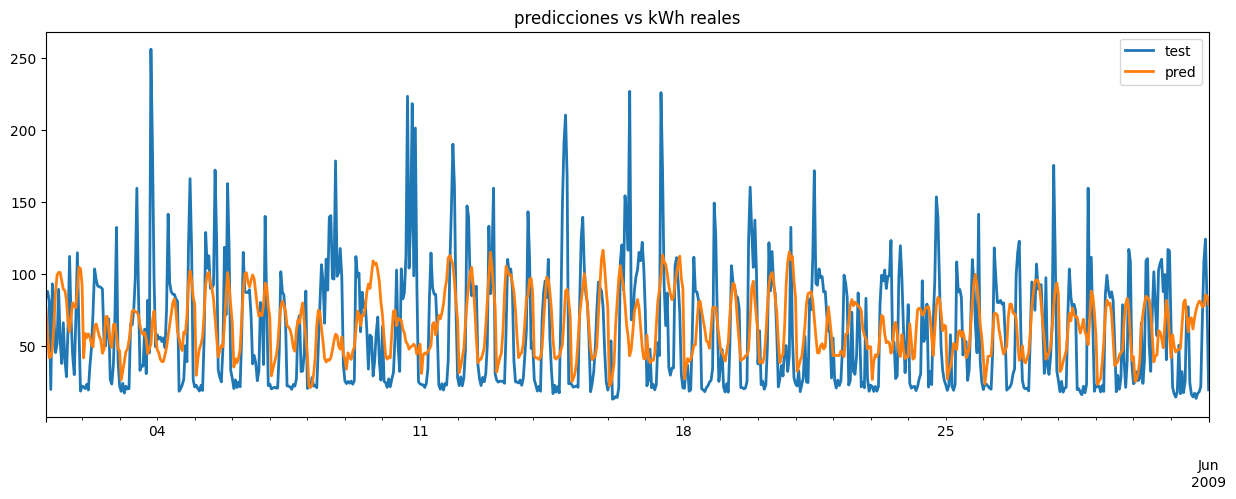

In [178]:
fig, ax = plt.subplots(figsize=(15,5))
datos.loc[predicciones.index,'Global_active_power'].plot(ax=ax,linewidth=2,label='test')
predicciones.plot(linewidth=2, label='Prediccion',ax=ax)
ax.set_title('predicciones vs kWh reales')
ax.legend()

## Storytelling
Como se ve a simple vista, el modelo intenta parecerse, pero no logra llegar, en algunos casos podria decirse que:
- Capta su estructura, patron o comportamiento pero no la magnitud de las observaciones.
- No capta su estructura y tampoco su magnitud
- Los valores atipicos generan mayor ruido en la serie.

In [179]:
# grafico interactivo
datos_plot = pd.DataFrame({
    'test': datos_test['Global_active_power'],
    'prediccion':predicciones['pred'],
})
datos_plot.index.name = 'date_time'

fig = px.line(
    data_frame=datos_plot.reset_index(),
    x = 'date_time',
    y = datos_plot.columns,
    title = 'Cantidad de energia activa en kWh',
    width=1200,
    height= 500
)
fig.update_xaxes(rangeslider_visible=True)
fig.show()

## Backtesting con intervalos

In [180]:
metrica, predicciones = backtesting_forecaster(
    forecaster= forecaster,
    y = datos['Global_active_power'],
    initial_train_size= len(datos.loc[:fin_validacion]),
    steps = 24,
    interval= [5,95], # intervalo del 90% 
    n_boot= 100,
    metric = 'mean_absolute_error',
    refit = False,
    verbose= True
)
predicciones.head()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 20383, number of used features: 24
[LightGBM] [Info] Start training from score 66.790628
Information of backtesting process
----------------------------------
Number of observations used for initial training: 20407
Number of observations used for backtesting: 744
    Number of folds: 31
    Number of steps per fold: 24
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2007-01-01 18:00:00 -- 2009-05-01 00:00:00  (n=20407)
    Validation: 2009-05-01 01:00:00 -- 2009-05-02 00:00:00  (n=24)
Fold: 1
    Training:   2007-01-01 18:00:00 -- 2009-05-01 00:00:00  (n=20407)
    Validation: 2009-05-02 01:00:00 -- 2009-05-03 00:00:00  (n=24)
Fold: 2
    Training:   2007-01-01 18:00:00 -- 2009

  0%|          | 0/31 [00:00<?, ?it/s]

pred  lower_bound  upper_bound
2009-05-01 01:00:00  75.683445    28.262107   139.587932
2009-05-01 02:00:00  56.597879     5.592769   146.945661
2009-05-01 03:00:00  41.927141   -10.673367   141.771773
2009-05-01 04:00:00  42.742155   -15.333348   141.711367
2009-05-01 05:00:00  47.389030    -2.359835   129.247735

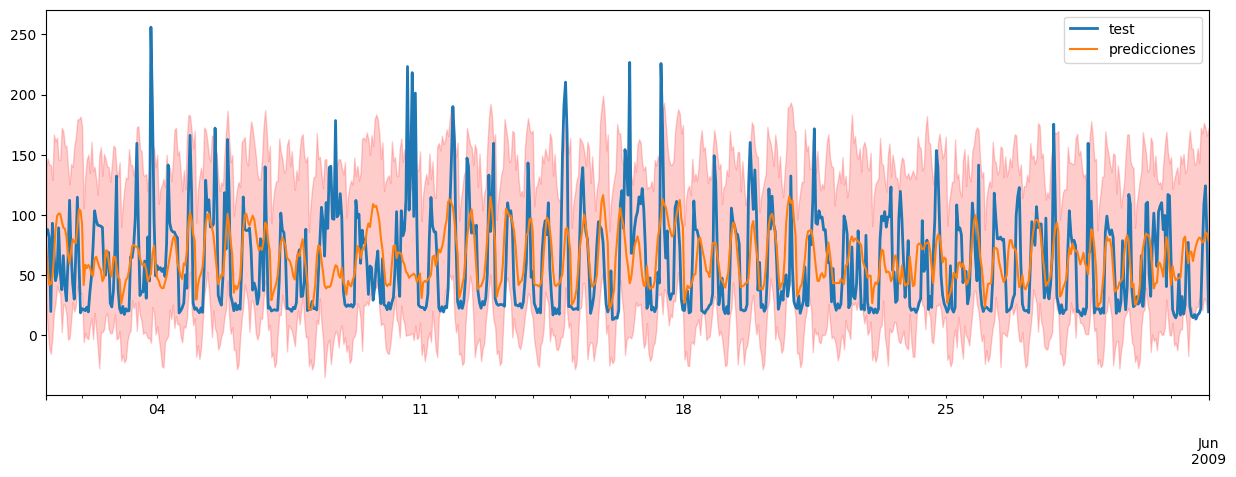

In [181]:
# Grafico
fig, ax = plt.subplots(figsize=(15,5))
datos.loc[predicciones.index,'Global_active_power'].plot(ax=ax,linewidth=2,label='test')
predicciones['pred'].plot(ax=ax, label='predicciones')
ax.fill_between(
    predicciones.index,
    predicciones['lower_bound'],
    predicciones['upper_bound'],
    color='red',
    alpha= 0.2
)
ax.legend()

## Uso del grid_search_forecaster
Con esta herramienta podemos concluir cuales son los mejores hiperparametros del grid.

In [182]:
#grid search de hiperparametros
#hiperparametros del regresor
param_grid = {
    'max_iter':[100,500], # numero de arboles que forman parte del modelo de gradint boosting
    'max_depth':[3,10], # Profundidad maxima del arbol
    'learning_rate':[0.01,0.1]
}
#lags utilizados como predictores
lags_grid = [24,48,[1,2,24]]

resultados_grid = grid_search_forecaster(
    forecaster= forecaster,
    y = datos.loc[:fin_validacion,'Global_active_power'], # conjunto de train + validacion
    param_grid = param_grid,
    lags_grid= lags_grid,
    steps = 24,
    refit = False,
    metric = 'mean_absolute_error',
    initial_train_size= int(len(datos_train)), # el modelo se entrena con los datos de entrenamiento
    return_best= True,
    verbose = False,
    show_progress=True
)

Number of models compared: 24.


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/8 [00:00<?, ?it/s]

[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 18895, number of used features: 24
[LightGBM] [Info] Start training from score 66.455066


c:\Users\Pablo\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `max_iter` in params. Will use it instead of argument

c:\Users\Pablo\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `max_iter` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=500, max_iter=500 will be ignored. Current value: num_iterations=500
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000735 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 18895, number of used features: 24
[LightGBM] [Info] Start training from score 66.455066
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

c:\Users\Pablo\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `max_iter` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 18895, number of used features: 24
[LightGBM] [Info] Start training from score 66.455066
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accu

c:\Users\Pablo\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `max_iter` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=500, max_iter=500 will be ignored. Current value: num_iterations=500
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 18895, number of used features: 24
[LightGBM] [Info] Start training from score 66.455066
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accu

c:\Users\Pablo\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `max_iter` in params. Will use it instead of argument

c:\Users\Pablo\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `max_iter` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=500, max_iter=500 will be ignored. Current value: num_iterations=500
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 18895, number of used features: 24
[LightGBM] [Info] Start training from score 66.455066
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

c:\Users\Pablo\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `max_iter` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 18895, number of used features: 24
[LightGBM] [Info] Start training from score 66.455066
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accu

c:\Users\Pablo\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `max_iter` in params. Will use it instead of argument



[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

c:\Users\Pablo\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `max_iter` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12240
[LightGBM] [Info] Number of data points in the train set: 18871, number of used features: 48
[LightGBM] [Info] Start training from score 66.473310


c:\Users\Pablo\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `max_iter` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=500, max_iter=500 will be ignored. Current value: num_iterations=500
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12240
[LightGBM] [Info] Number of data points in the train set: 18871, number of used features: 48
[LightGBM] [Info] Start training from score 66.473310
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

c:\Users\Pablo\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `max_iter` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12240
[LightGBM] [Info] Number of data points in the train set: 18871, number of used features: 48
[LightGBM] [Info] Start training from score 66.473310
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Acc

c:\Users\Pablo\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `max_iter` in params. Will use it instead of argument



[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

c:\Users\Pablo\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `max_iter` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12240
[LightGBM] [Info] Number of data points in the train set: 18871, number of used features: 48
[LightGBM] [Info] Start training from score 66.473310
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

c:\Users\Pablo\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `max_iter` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=500, max_iter=500 will be ignored. Current value: num_iterations=500
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12240
[LightGBM] [Info] Number of data points in the train set: 18871, number of used features: 48
[LightGBM] [Info] Start training from score 66.473310
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

c:\Users\Pablo\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `max_iter` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004517 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12240
[LightGBM] [Info] Number of data points in the train set: 18871, number of used features: 48
[LightGBM] [Info] Start training from score 66.473310
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Acc

c:\Users\Pablo\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `max_iter` in params. Will use it instead of argument



[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

c:\Users\Pablo\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `max_iter` in params. Will use it instead of argument

c:\Users\Pablo\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `max_iter` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=500, max_iter=500 will be ignored. Current value: num_iterations=500
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 18895, number of used features: 3
[LightGBM] [Info] Start training from score 66.455066
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

c:\Users\Pablo\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `max_iter` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 18895, number of used features: 3
[LightGBM] [Info] Start training from score 66.455066
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accura

c:\Users\Pablo\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `max_iter` in params. Will use it instead of argument



[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

c:\Users\Pablo\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `max_iter` in params. Will use it instead of argument

c:\Users\Pablo\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `max_iter` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=500, max_iter=500 will be ignored. Current value: num_iterations=500
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 18895, number of used features: 3
[LightGBM] [Info] Start training from score 66.455066
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

c:\Users\Pablo\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `max_iter` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 18895, number of used features: 3
[LightGBM] [Info] Start training from score 66.455066
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accura

c:\Users\Pablo\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `max_iter` in params. Will use it instead of argument



[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

c:\Users\Pablo\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `max_iter` in params. Will use it instead of argument



[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'learning_rate': 0.01, 'max_depth': 10, 'max_iter': 500}
  Backtesting metric: 31.09730756393504



In [183]:
resultados_grid.head(10)

lags  \
11  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
5   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
13  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
14  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
12  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
7   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
15  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
6   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
3   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
9   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   

                                               params  mean_absolute_error  \
11  {'learning_rate': 0.01, 'max_depth': 10, 'max_...            31.097308   
5   {'learning_rate': 0.1, 'max_depth': 3, 'max_it...            31.194729   
13  {'learning_rate': 0.1, 'max_depth': 3, 'max_it...            31.216349   
14  {'learning_rate': 0.1, 'max_depth': 10, 'max_i...            31.227603   
12  {'learning_rate': 0.1, 'max_depth': 3, 'max_it...            31.333893   
7   {'learning_rate': 0.1, 'max_depth': 10, 'max_i...            31.392711   
15  {'learning_rate': 0.1, 'max_depth': 10, 'max_i...            31.434693   
6   {'learning_rate': 0.1, 'max_depth': 10, 'max_i...            31.481847   
3   {'learning_rate': 0.01, 'max_depth': 10, 'max_...            31.652928   
9   {'learning_rate': 0.01, 'max_depth': 3, 'max_i...            31.667581   

    learning_rate  max_depth  max_iter  
11           0.01       10.0     500.0  
5            0.10        3.0     500.0  
13           0.10        3.0     500.0  
14           0.10       10.0     100.0  
12           0.10        3.0     100.0  
7            0.10       10.0     500.0  
15           0.10       10.0     500.0  
6            0.10       10.0     100.0  
3            0.01       10.0     500.0  
9            0.01        3.0     500.0

## Mejora del modelo con los mejores hiperparametros

In [184]:
metrica, predicciones = backtesting_forecaster(
    forecaster= forecaster,
    y = datos.Global_active_power,
    initial_train_size= len(datos.loc[:fin_validacion]),
    steps = 24,
    metric = 'mean_absolute_error',
    refit = False,
    verbose= False
)
print(f"backtest error: ",{metrica})

c:\Users\Pablo\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `max_iter` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=500, max_iter=500 will be ignored. Current value: num_iterations=500
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12240
[LightGBM] [Info] Number of data points in the train set: 20359, number of used features: 48
[LightGBM] [Info] Start training from score 66.807935


  0%|          | 0/31 [00:00<?, ?it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

In [185]:
forecaster = ForecasterAutoreg(
    regressor= LGBMRegressor(max_depth=3,learning_rate=0.1,n_estimators=100),
    lags = 48
)
forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(max_depth=3) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
Transformer for y: None 
Transformer for exog: None 
Window size: 48 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 3, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0} 
fit_kwargs: {} 
Creation date: 2024-05-31 0

# Entrenar el modelo con variables exogenas

Se debe pasar los datos de "y" de respuesta y los datos de respuesta de las variables exogenas

In [186]:
variables_exog = ['Global_reactive_power','power_factor','Voltage']

forecaster.fit(
    y = datos.loc[:fin_validacion, 'Global_active_power'],
    exog = datos.loc[:fin_validacion,variables_exog]
)
forecaster

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002909 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13005
[LightGBM] [Info] Number of data points in the train set: 20359, number of used features: 51
[LightGBM] [Info] Start training from score 66.807935
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

ForecasterAutoreg 
Regressor: LGBMRegressor(max_depth=3) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
Transformer for y: None 
Transformer for exog: None 
Window size: 48 
Weight function included: False 
Differentiation order: None 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['Global_reactive_power', 'power_factor', 'Voltage'] 
Training range: [Timestamp('2007-01-01 18:00:00'), Timestamp('2009-05-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 3, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': None,

In [187]:
# prediccion
exog_siguientes_24h = datos_test[variables_exog][1:25]
# NOTA: Para que la variable "exog" este un paso adelante para poder realizar las predicciones,
# la variable exog_siguientes_24h, se le pasa como indice, las variables y el comienzo de los datos apartir de 1.
predicciones = forecaster.predict(steps=24,exog=exog_siguientes_24h)
predicciones

2009-05-01 01:00:00     91.693508
2009-05-01 02:00:00     95.724237
2009-05-01 03:00:00     82.402001
2009-05-01 04:00:00     29.416796
2009-05-01 05:00:00     94.764217
2009-05-01 06:00:00     65.176131
2009-05-01 07:00:00     74.589282
2009-05-01 08:00:00     46.084607
2009-05-01 09:00:00    102.696506
2009-05-01 10:00:00     64.157741
2009-05-01 11:00:00     46.559949
2009-05-01 12:00:00     88.630066
2009-05-01 13:00:00     64.466727
2009-05-01 14:00:00     33.613969
2009-05-01 15:00:00     46.359207
2009-05-01 16:00:00    122.868126
2009-05-01 17:00:00     83.575540
2009-05-01 18:00:00     58.461964
2009-05-01 19:00:00     34.210958
2009-05-01 20:00:00     54.359618
2009-05-01 21:00:00     99.654609
2009-05-01 22:00:00     51.541175
2009-05-01 23:00:00     19.647832
2009-05-02 00:00:00     23.237400
Freq: H, Name: pred, dtype: float64

# Backtesting con mejores hiperparametros y variables exogenas

In [188]:
metrica, predicciones = backtesting_forecaster(
    forecaster= forecaster,
    y = datos['Global_active_power'],
    exog = datos[variables_exog],
    initial_train_size= len(datos.loc[:fin_validacion]),
    steps = 24,
    metric = 'mean_absolute_error',
    refit = False,
    verbose= False
)
metrica

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002720 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13005
[LightGBM] [Info] Number of data points in the train set: 20359, number of used features: 51
[LightGBM] [Info] Start training from score 66.807935
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

  0%|          | 0/31 [00:00<?, ?it/s]

10.914577073542686

El valor de la metrica sin normalizacion se mejoro a desde 30 a 11(mean_absolute_error)

El valor de la metrica con normalizacion se mejoro a desde 0,15 a 0,05 

## Grafico con mejores hiperparametros

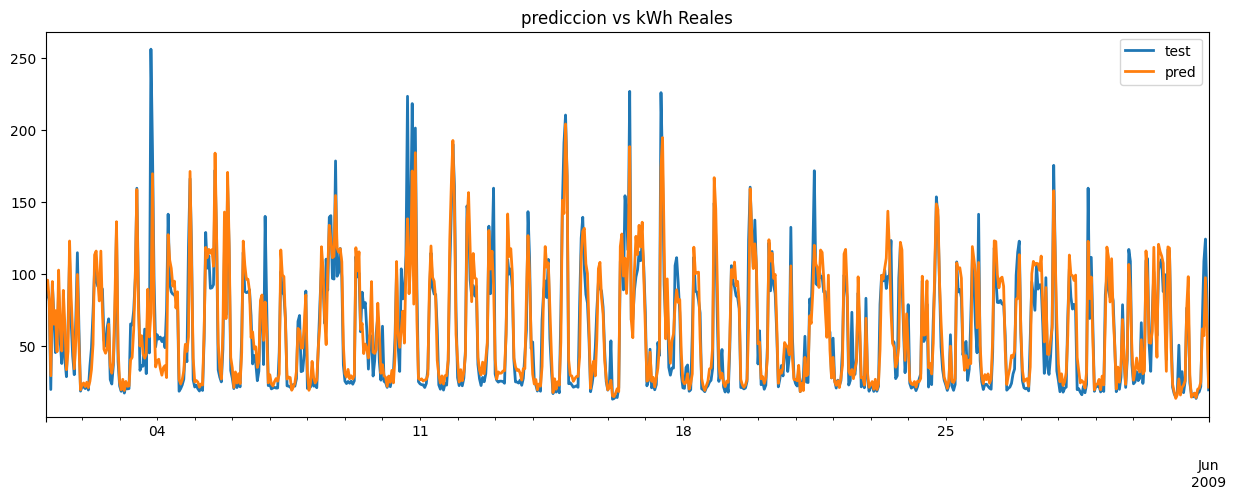

In [189]:
#grafico

fig, ax = plt.subplots(figsize=(15,5))
datos.loc[predicciones.index,'Global_active_power'].plot(ax=ax,linewidth=2,label='test')
predicciones.plot(linewidth=2,label='prediccion',ax=ax)
ax.set_title('prediccion vs kWh Reales')
ax.legend()

importancia de predictores

In [190]:
forecaster.get_feature_importances().sort_values('importance',ascending=False)

feature  importance
49           power_factor         257
48  Global_reactive_power         199
0                   lag_1          59
50                Voltage          41
1                   lag_2          19
2                   lag_3           9
9                  lag_10           8
22                 lag_23           8
5                   lag_6           7
8                   lag_9           6
10                 lag_11           6
33                 lag_34           5
3                   lag_4           5
46                 lag_47           5
32                 lag_33           4
19                 lag_20           4
4                   lag_5           4
21                 lag_22           3
45                 lag_46           3
35                 lag_36           3
24                 lag_25           3
11                 lag_12           3
6                   lag_7           3
34                 lag_35           3
29                 lag_30           3
16                 lag_17           2
42                 lag_43           2
26                 lag_27           2
41                 lag_42           2
40                 lag_41           1
38                 lag_39           1
25                 lag_26           1
31                 lag_32           1
20                 lag_21           1
7                   lag_8           1
12                 lag_13           1
17                 lag_18           1
28                 lag_29           1
37                 lag_38           0
36                 lag_37           0
39                 lag_40           0
18                 lag_19           0
30                 lag_31           0
15                 lag_16           0
43                 lag_44           0
44                 lag_45           0
14                 lag_15           0
13                 lag_14           0
47                 lag_48           0
23                 lag_24           0
27                 lag_28           0

## Modelo en produccion

In [191]:
forecaster.fit(y=datos.loc[:fin_validacion,'Global_active_power'])
forecaster

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002741 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12240
[LightGBM] [Info] Number of data points in the train set: 20359, number of used features: 48
[LightGBM] [Info] Start training from score 66.807935
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

ForecasterAutoreg 
Regressor: LGBMRegressor(max_depth=3) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
Transformer for y: None 
Transformer for exog: None 
Window size: 48 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2007-01-01 18:00:00'), Timestamp('2009-05-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 3, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200

# Predicciones seguidas de los datos utilizados para entrenar el modelo
La ultima fecha que el forecaster utilizo en el entrenamiento es del '2009-05-01 00:00:00', cuando llamemos al metodo predict, por defecto comenzara apartir de esta fecha.

In [192]:
predicciones = forecaster.predict(steps=24)
predicciones.head()

2009-05-01 01:00:00    65.411128
2009-05-01 02:00:00    47.118053
2009-05-01 03:00:00    38.481712
2009-05-01 04:00:00    40.153627
2009-05-01 05:00:00    49.455490
Freq: H, Name: pred, dtype: float64

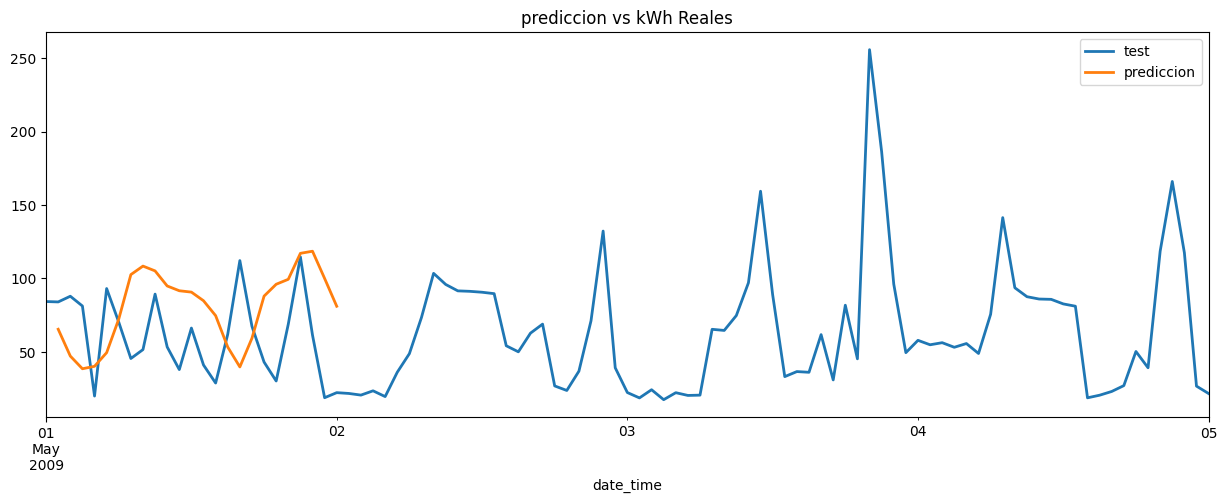

In [193]:
#grafico

fig, ax = plt.subplots(figsize=(15,5))
datos_test.loc[:'2009-05-05 00:00:00','Global_active_power'].plot(ax=ax,linewidth=2,label='test')
predicciones.plot(linewidth=2,label='prediccion',ax=ax)
ax.set_title('prediccion vs kWh Reales')
ax.legend()

# predicciones en un instante determinado de tiempo

In [194]:
datos_ultimos_72h = datos.loc['2009-05-02 01:00:00':'2009-05-05 01:00:00','Global_active_power']
predicciones = forecaster.predict(steps=24,last_window = datos_ultimos_72h)
predicciones.head()

2009-05-05 02:00:00    32.106746
2009-05-05 03:00:00    35.355008
2009-05-05 04:00:00    38.753829
2009-05-05 05:00:00    45.240104
2009-05-05 06:00:00    68.699353
Freq: H, Name: pred, dtype: float64

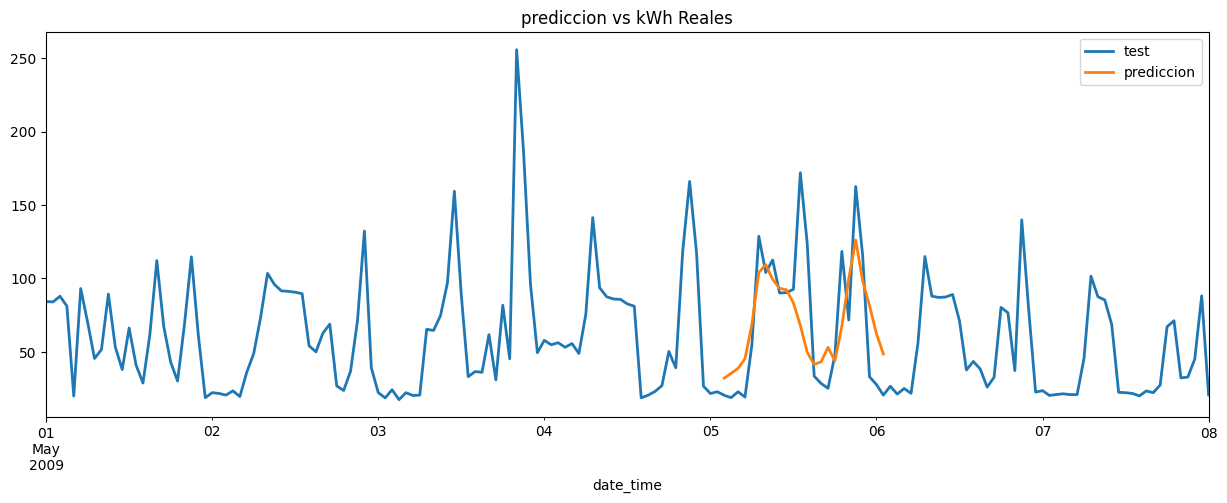

In [195]:
fig, ax = plt.subplots(figsize=(15,5))
datos_test.loc[:'2009-05-08 00:00:00','Global_active_power'].plot(ax=ax,linewidth=2,label='test')
predicciones.plot(linewidth=2,label='prediccion',ax=ax)
ax.set_title('prediccion vs kWh Reales')
ax.legend()